In [ ]:
!rm -rf /root/.kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:11<00:00, 198MB/s]
100% 1.33G/1.33G [00:11<00:00, 123MB/s]


In [ ]:
!mkdir celeba
!mv celeba-dataset.zip celeba

In [ ]:
%cd celeba
!unzip -q celeba-dataset.zip
%cd ..

/content/celeba
/content


In [ ]:
!cp /content/drive/MyDrive/celebAgreyscale/celeba/*.txt /content/celeba

In [ ]:
!mv /content/celeba/img_align_celeba /content/celeba/img_align_celeba_2
!mv /content/celeba/img_align_celeba_2/img_align_celeba /content/celeba/img_align_celeba

In [ ]:
!mkdir celebaholder
!mv celeba celebaholder

In [ ]:
%%bash
git clone https://github.com/AntixK/PyTorch-VAE
cd PyTorch-VAE
pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.4/525.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 55.1 MB/s eta 0:00:00


Cloning into 'PyTorch-VAE'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
%cd PyTorch-VAE

/content/PyTorch-VAE


In [ ]:
!pip install lmdb -q

In [ ]:
from models.vq_vae import VQVAE
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch import nn
import math
import os

In [ ]:
transform = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CelebA(root='/content/celebaholder', split = "train",
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=0)

testset = torchvision.datasets.CelebA(root='/content/celebaholder', split = "test",
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [ ]:
# Sinusoidal Time Embedded Conditioned Feed Forward Network
class STEFF(nn.Module):
  def __init__(self, max_time_steps, input_dim, depth, act_fn):
    super().__init__()
    self.ff = nn.ModuleList()
    for _ in range(depth):
      self.ff.append(nn.Sequential(nn.Linear(input_dim, input_dim), act_fn()))
    self.depth = depth
    self.emb = SinusoidalPosEmb(input_dim)
    self.max_time_steps = max_time_steps
  def forward(self, X, T):
    nX = X
    for i in range(self.depth):
      nX = nX + (self.ff[i](nX * self.emb(T / self.max_time_steps)))
    return nX
# Learned Time Embedded Conditioned Feed Forward Network
class LTEFF(nn.Module):
  def __init__(self, max_time_steps, input_dim, depth, act_fn):
    super().__init__()
    self.ff = nn.ModuleList()
    for _ in range(depth):
      self.ff.append(nn.Sequential(nn.Linear(input_dim, input_dim), act_fn()))
    self.depth = depth
    self.emb = nn.Embedding(max_time_steps, input_dim)
    self.max_time_steps = max_time_steps
  def forward(self, X, T):
    nX = X
    cX = self.emb(T.int())
    for i in range(self.depth):
      nX = nX + (self.ff[i](nX) * cX)
    return nX

In [ ]:
def linear_projection(iX, oX, T):
  return iX + (oX - iX) * torch.reshape(T, (-1,1))

In [ ]:
device = 'cuda'


max_steps = 50
latent_dim = 32*16*16
max_depth = 8

vae = VQVAE(in_channels = 3, embedding_dim = 32, num_embeddings = 512, latent_dim = 128, num_classes = 2, beta = 0.25)
vae.load_state_dict(torch.load('/content/drive/MyDrive/celebAgreyscale/vae_32_16_16.pt'))
vae.to(device)
vae.eval()

act_fn = nn.ReLU
lcdm = STEFF(max_steps, latent_dim, max_depth, act_fn).to(device)

In [ ]:
# T = torch.randint(low = 0, high = max_steps, size = (1,64), dtype = float).to(device)
# starting_positions = linear_projection(grayscale_embeds, color_embeds, T)
# iX = torch.flatten(grayscale_embeds, start_dim = 1)
# oX = torch.flatten(color_embeds, start_dim = 1)
# T = torch.randint(low = 0, high = max_steps, size = (64,), dtype = torch.float32).to(device)
# starting_positions = linear_projection(grayscale_embeds, color_embeds, T)
# lcdm(starting_positions, T)

In [ ]:
num_epochs = 10
optimizer = torch.optim.AdamW(lcdm.parameters(), lr=0.0001)
for epoch in range(1, num_epochs + 1):
  try:
    for (data, labels) in trainloader:
      if os.path.isfile('stop'):
        break
      with torch.no_grad():
        color = data.to(device)
        grayscale = torchvision.transforms.Grayscale(num_output_channels=3)(color).to(device)
        color_embeds = torch.flatten(vae.encode(color)[0], start_dim = 1)
        grayscale_embeds = torch.flatten(vae.encode(grayscale)[0], start_dim = 1)
        B = grayscale_embeds.size()[0]
        T = torch.randint(low = 0, high = max_steps, size = (B,), dtype = torch.float32).to(device)
        starting_positions = linear_projection(grayscale_embeds, color_embeds, T / max_steps)


      optimizer.zero_grad()

      predicted_color_embeds = lcdm(starting_positions, T)
      loss = F.mse_loss(predicted_color_embeds, color_embeds)

      loss.backward()
      print(math.sqrt(loss.item()) / torch.mean(color_embeds).item(), torch.mean(T).item())
      optimizer.step()
  except:
    continue


6.891414724657912 26.65625
2.6756924335678263 25.359375
1.695981303809931 23.53125
1.235199375271967 23.5625
0.9300470673318223 24.921875
0.9489407962500938 23.578125
0.9356275104587087 23.984375
0.7696362138392664 23.375
0.6337031917256767 24.3125
0.8465290647985354 25.0625
0.879571461021606 25.203125
0.5232428525885305 27.046875
0.6940678981985748 24.46875
0.8107234575118468 27.234375
0.6825012585305487 23.6875
0.5903629986735489 25.203125
0.7442369825613907 24.484375
0.6532068057192906 24.515625
0.6866573396582528 21.375
0.802865014584398 24.71875
0.5947116133381897 25.640625
0.6468085632964833 26.390625
0.5869472046412259 24.453125
1.0551670890334837 25.265625
0.6099005647637407 23.515625
0.562950038805182 21.703125
0.5481168428799191 23.25
0.5963382005204186 23.953125
0.6303562127255801 25.3125
0.6027307561324109 26.3125
0.5149075825999387 25.984375
0.5742502824608987 26.875
0.6548857672924552 23.46875
0.6708151324943303 25.125
0.5673571915719222 19.515625
0.5869826846434687 23.68

In [ ]:
torch.save(lcdm.state_dict(), '/content/drive/MyDrive/celebAgreyscale/STEFF_8_RELU.pt')

In [ ]:
def sample_cdm(iX, T, lcdm, device):
  pX = iX
  B = pX.size()[0]
  cX = lcdm(pX, (torch.zeros(size = (B,), dtype = torch.int))).to(device)
  for i in range(1, T):
    T = (torch.ones(size = (B,)) * i).to(device)
    icX = linear_projection(pX, cX)

In [ ]:
torch.clone(torch.FloatTensor([1,2,3]))

tensor([1., 2., 3.])

In [ ]:
# function sample_ddm_improved(x_T)
#     px_s = x_T
#     x_0 = x_T
#     for s in T:-1:1
#         x_0 = ddm(px_s, s)
#         px_s = px_s - forward(x_0, x_T, s, T) + forward(x_0, x_T, s-1, T)
#     end
#     return px_s
# end

In [ ]:
def sample_ddm_improved(x_T, max_T, lcdm, device):
  px_s = x_T
  x_0 = x_T
  for s in range(max_T, 1, -1):
    S = (torch.ones(size = (B,)) * i).to(device)
    x_0 = lcdm(px_s, S)
    px_s = px_s - linear_projection(x_0, x_T, S / max_T) + linear_projection(x_0, x_T, (S - 1) / max_T)
  return x_0

In [ ]:
data, labels = next(iter(testloader))

with torch.no_grad():
  color = data.to(device)
  grayscale = torchvision.transforms.Grayscale(num_output_channels=3)(color).to(device)
  color_embeds = torch.flatten(vae.encode(color)[0], start_dim = 1)
  grayscale_embeds = torch.flatten(vae.encode(grayscale)[0], start_dim = 1)
  B = grayscale_embeds.size()[0]
  T = torch.randint(low = 0, high = max_steps, size = (B,), dtype = torch.float32).to(device)
  starting_positions = linear_projection(grayscale_embeds, color_embeds, T / max_steps)
dec = lcdm(grayscale_embeds, torch.ones(size = (B,)).to(device))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
recon_color_data = vae.decode(torch.reshape(dec, (64, 32, 16, 16)))
recon_grayscale = vae.decode(torch.reshape(grayscale_embeds, (65, 32, 16, 16)))

In [ ]:
import random

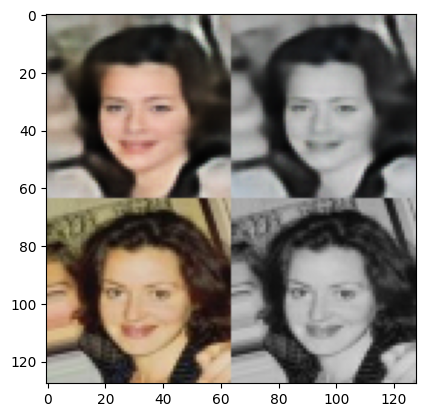

In [ ]:
i = random.randint(0, 63)
color_recon_img = ((recon_color_data[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_recon_img = ((recon_grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
color_img = ((color[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_img = ((grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()

recons = torch.cat((color_recon_img, grayscale_recon_img), 1)
origs = torch.cat((color_img, grayscale_img), 1)
plt.imshow(torch.cat((recons, origs), 0))

In [ ]:
import gc
gc.collect()

159

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dec_improved = sample_ddm_improved(grayscale_embeds, max_steps, lcdm, device)

OutOfMemoryError: ignored

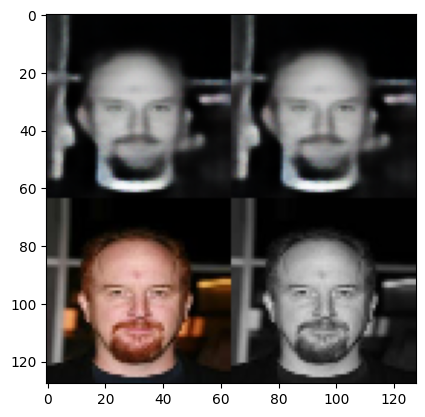

In [ ]:
i = random.randint(0, 63)
# recon_color_data_improved = vae.decode(torch.reshape(dec_improved, (64, 32, 16, 16)))
color_recon_img = ((recon_color_data_improved[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_recon_img = ((recon_grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
color_img = ((color[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()
grayscale_img = ((grayscale[i] + 1)/2).permute(1, 2, 0).to('cpu').detach()

recons = torch.cat((color_recon_img, grayscale_recon_img), 1)
origs = torch.cat((color_img, grayscale_img), 1)
plt.imshow(torch.cat((recons, origs), 0))

In [ ]:
iX = eX[0:2, :]
oX = torch.ones(iX.size())
# iX + (oX - iX) * torch.ones(9,1)

(oX - iX), ((oX - iX) * (torch.FloatTensor([[.8], [.5]])))
# .size()
# torch.ones(2, 1).size()
linear_projection(iX, oX, torch.FloatTensor([1, .5]))

In [ ]:
iX

In [ ]:
32*16*16

In [ ]:
T = torch.randint(low = 0, high = 10, size = (2,), dtype = float)
STEFF(10, 32*16*16, 3, nn.SELU)(iX, T)